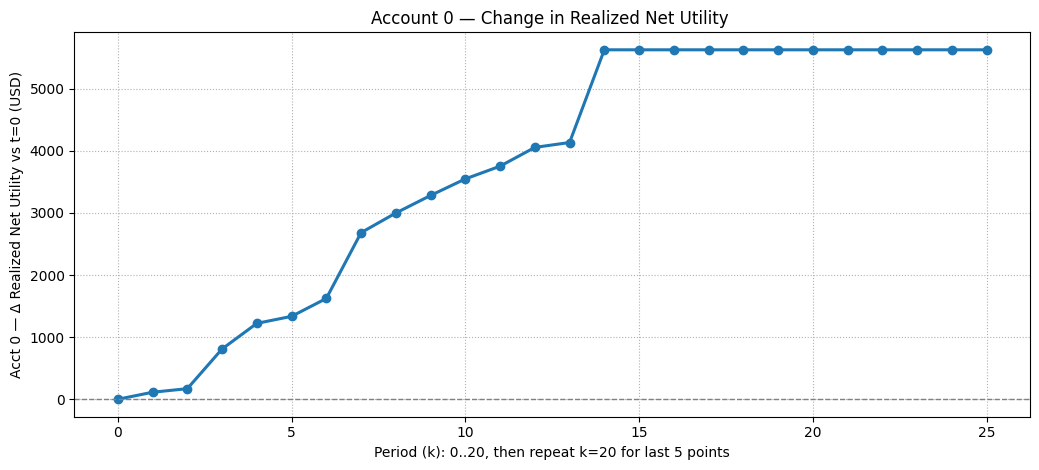

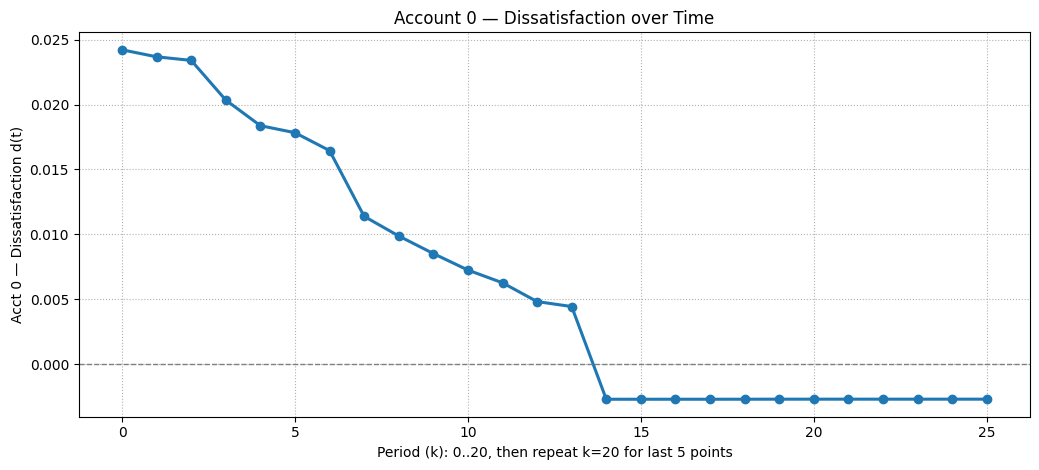

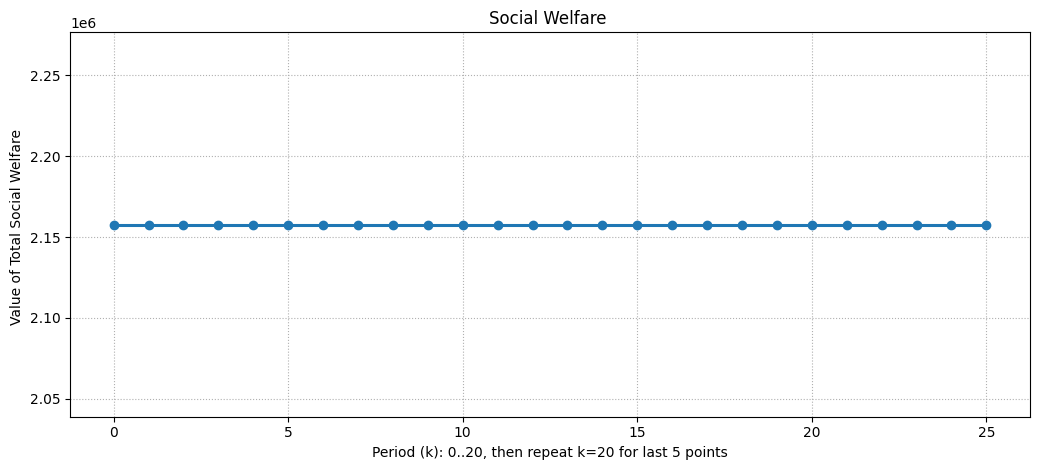

=== Summary ===
Accounts: ['Acct 0', 'Acct 1', 'Acct 2', 'Acct 3', 'Acct 4', 'Acct 5', 'Acct 6', 'Acct 7', 'Acct 8', 'Acct 9']
C_tot (fixed) = 66,935.30
Saved CSV: all_accounts_colsweep_timeseries.csv
Saved figs: fig1_acct0_realized_net_delta.png, fig2_acct0_dissatisfaction.png, fig3_social_welfare.png
Acct 0 realized net — start: 204,208.69 | end: 209,836.11 | Δ: 5,627.42
Social Welfare — start: 2,157,709.60 | end: 2,157,709.60 | Δ: 0.00


In [12]:
# -*- coding: utf-8 -*-
"""
One-period-lag rebates (posted to InfoPool only), FairSplit recomputed every period.

Figures:
  (1) Acct 0 — Δ Realized Net Utility (collusive) vs t=0
  (2) Acct 0 — Dissatisfaction d(t)
  (3) Social Welfare (sum of realized collusive)

Ledgers:
- Realized (collusive):  U_realized_j(t) = u_col_j - r_j(t) * C_tot      [NO rebates]
- InfoPool incentive:    U_info_j(t)     = U_pool_j(t) + R_j(t)          [rebates posted]
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Settings
# -----------------------------
BATCH_DIR = r"infopool_batch_outputs_colsweep"  # change if needed
FILE_COL  = "collusive.csv"                      # must have column 'u_col'
FILE_CTOT = "total_cost.txt"                     # single float
EPS = 1e-12
EXTRA_STEADY_STEPS = 5       # repeat k=20 for last 5 points
EXPECT_N = 10                # number of accounts

# Rebate policy (carry-over)
ETA_DEFAULT   = 1.0          # η: fraction of last-period surplus injected
DELTA_DECAY   = 0.0          # δ: bucket decay

# -----------------------------
# Helpers
# -----------------------------
def _read_csv(path, **kw):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")
    return pd.read_csv(path, **kw)

def tag(k: int) -> str:
    return f"taucols_k{k:02d}"

def load_acct_perf(k: int) -> pd.DataFrame:
    p = os.path.join(BATCH_DIR, f"account_performance_{tag(k)}.csv")
    return _read_csv(p, index_col=0)

def load_trades(k: int) -> pd.DataFrame:
    p = os.path.join(BATCH_DIR, f"asset_trades_{tag(k)}.csv")
    return _read_csv(p)

def load_pool(k: int) -> pd.DataFrame:
    p = os.path.join(BATCH_DIR, f"asset_pool_{tag(k)}.csv")
    return _read_csv(p)

# def compute_r_equal_dissatisfaction(U_pool: np.ndarray,
#                                     u_col: np.ndarray,
#                                     C_tot: float,
#                                     eps: float = EPS) -> np.ndarray:
#     # equal dissatisfaction: a_j + b_j r_j are equal across j
#     U_safe = np.maximum(U_pool, eps)
#     a = 1.0 - (u_col / U_safe)
#     b = C_tot / U_safe
#     den = np.sum(1.0 / b)
#     lam = (1.0 + np.sum(a / b)) / max(den, eps)
#     r_star = (lam - a) / b
#     r = np.clip(r_star, 0.0, None)
#     s = r.sum()
#     return (r / s) if s > eps else np.ones_like(r) / len(r)
def compute_r_equal_dissatisfaction(U_pool: np.ndarray,
                                    u_col: np.ndarray,
                                    C_tot: float,
                                    eps: float = 1e-12) -> np.ndarray:
    """
    Minimize Var(d) s.t. r >= 0, sum r = 1, where
      d_j = a_j + b_j r_j,
      a_j = 1 - u_col_j / U_pool_j,
      b_j = C_tot / U_pool_j.
    Active-set solver: enforce r_j >= 0 exactly (KKT).
    """
    U_safe = np.maximum(U_pool, eps)
    a = 1.0 - (u_col / U_safe)
    b = C_tot / U_safe

    # Active set initialization: all j are included
    active = np.ones_like(a, dtype=bool)
    r = np.zeros_like(a)

    while True:
        
        den = np.sum(active / b)  # sum(1/b_j) over active
        if den <= eps:
            
            r = np.zeros_like(a)
            r[active] = 1.0 / max(np.sum(active), 1)
            break

        lam = (1.0 + np.sum((a / b)[active])) / den  #  sum r = 1 
        r_temp = np.zeros_like(a)
        r_temp[active] = (lam - a[active]) / b[active]

        
        neg_mask = (r_temp < -1e-14) & active
        if np.any(neg_mask):
            active[neg_mask] = False
            continue  

       
        r = np.maximum(r_temp, 0.0)
        s = r.sum()
        r = r / (s if s > eps else 1.0)
        break

    return r

def parse_participants(s: str):
    if s is None:
        return []
    txt = str(s).strip()
    if not txt or txt.lower() == "nan":
        return []
    return [t.strip() for t in txt.split(";") if t.strip()]

def compute_S_from_trades(tr_prev: pd.DataFrame, pool_prev: pd.DataFrame, accounts, d) -> np.ndarray:
    """
    Compute S_i^{t-1} (annual) from previous trades and pool diags:
      S = 0.5*( (sum q+)^2 - sum q+^2 ) * Ω++_ii
        + 0.5*( (sum q-)^2 - sum q-^2 ) * Ω++_ii
        +      ( (sum q+)(sum q-) - sum(q+*q-) ) * Ω-_ii
    """
    pp = pool_prev.sort_values("i")
    Op_ii = pp["Omega_plus_ii"].to_numpy()
    Om_ii = pp["Omega_minus_ii"].to_numpy()

    qp = tr_prev.pivot_table(index="Account", columns="i", values="q_plus",
                             aggfunc="sum").reindex(index=accounts, columns=range(d), fill_value=0.0).to_numpy()
    qm = tr_prev.pivot_table(index="Account", columns="i", values="q_minus",
                             aggfunc="sum").reindex(index=accounts, columns=range(d), fill_value=0.0).to_numpy()

    Tplus, Tminus = qp.sum(axis=0), qm.sum(axis=0)
    sum_qp2, sum_qm2 = (qp**2).sum(axis=0), (qm**2).sum(axis=0)
    sum_qpqm = (qp*qm).sum(axis=0)

    cross_pp_daily = 0.5 * (Tplus**2  - sum_qp2)  * Op_ii
    cross_mm_daily = 0.5 * (Tminus**2 - sum_qm2)  * Op_ii
    cross_pm_daily =       (Tplus*Tminus - sum_qpqm) * Om_ii
    return 252.0 * (cross_pp_daily + cross_mm_daily + cross_pm_daily)

# -----------------------------
# 0) Read accounts, collusive u_col, C_tot
# -----------------------------
acct0_df = load_acct_perf(0)
accounts = acct0_df.index.tolist()
if len(accounts) != EXPECT_N:
    print(f"[WARN] Expect {EXPECT_N} accounts, found {len(accounts)}. Proceeding with detected accounts.")
N = len(accounts)

col_df = pd.read_csv(FILE_COL, index_col=0)
if "u_col" not in col_df.columns:
    raise ValueError("collusive.csv must contain column 'u_col'.")
u_col_all = col_df["u_col"].reindex(accounts)
if u_col_all.isnull().any():
    missing = list(u_col_all[u_col_all.isnull()].index)
    raise ValueError(f"collusive.csv is missing these accounts: {missing}")
u_col_vec = u_col_all.values.astype(float)

with open(FILE_CTOT, "r") as f:
    C_tot = float(f.read().strip())

tmp_pool = load_pool(0)
d = int(tmp_pool["i"].max() + 1) if "i" in tmp_pool.columns else len(tmp_pool)

# -----------------------------
# 1) Rebates (lagged) for k=0..20
# -----------------------------
rebates_list = []               # length 21; each is (N,) array
B_bucket = np.zeros(d)          # B_i^1 = 0
ETA = np.full(d, ETA_DEFAULT)
DELTA = np.full(d, DELTA_DECAY)

for k in range(0, 21):
    if k == 0:
        rebates_list.append(np.zeros(N, dtype=float))  # first period: no rebate
        continue

    trades_prev = load_trades(k-1)
    pool_prev   = load_pool(k-1)
    pool_curr   = load_pool(k)

    s_prev = trades_prev.pivot_table(index="Account", columns="i",
                                     values="s_self_annual_diag", aggfunc="sum") \
                        .reindex(index=accounts, columns=range(d), fill_value=0.0) \
                        .to_numpy()
    S_prev = compute_S_from_trades(trades_prev, pool_prev, accounts, d)  # (d,)

    parts_curr = pool_curr.sort_values("i")["participants"].tolist()

    R_vec = np.zeros(N, dtype=float)
    for i_asset in range(d):
        P_list = parse_participants(parts_curr[i_asset])
        A_i = ETA[i_asset] * S_prev[i_asset] + B_bucket[i_asset]   # available this period

        if A_i <= 0.0 or len(P_list) == 0:
            B_bucket[i_asset] = (1.0 - DELTA[i_asset]) * A_i
            continue

        denom, idxs = 0.0, []
        for name in P_list:
            if name in accounts:
                jidx = accounts.index(name)
                idxs.append(jidx); denom += s_prev[jidx, i_asset]

        if denom <= EPS:
            B_bucket[i_asset] = (1.0 - DELTA[i_asset]) * A_i
            continue

        alpha_i = A_i / denom
        paid = 0.0
        for jidx in idxs:
            r_j_i = alpha_i * s_prev[jidx, i_asset]
            R_vec[jidx] += r_j_i
            paid += r_j_i

        rem = max(A_i - paid, 0.0)
        B_bucket[i_asset] = (1.0 - DELTA[i_asset]) * rem

    rebates_list.append(R_vec)

# -----------------------------
# 2) FairSplit per period; build ledgers
# -----------------------------
realized_collusive_list = []   # per k: u_col - r*C_tot
info_ledger_list        = []   # per k: U_pool + rebate
U_pool_store            = []   # keep U_pool for dissatisfaction

for k in range(0, 21):
    perf_k = load_acct_perf(k)
    if "Net Utility" not in perf_k.columns:
        raise ValueError(f"account_performance_{tag(k)}.csv must have column 'Net Utility'")
    U_pool_k = perf_k["Net Utility"].reindex(accounts).values.astype(float)
    U_pool_store.append(U_pool_k)

    r_k = compute_r_equal_dissatisfaction(U_pool_k, u_col_vec, C_tot)

    realized_k = u_col_vec - r_k * C_tot               # collusive ledger (actual)
    info_k     = U_pool_k + rebates_list[k]            # InfoPool ledger (incentive)

    realized_collusive_list.append(realized_k)
    info_ledger_list.append(info_k)

# -----------------------------
# 3) Steady extension (repeat k=20) — buckets still evolve
# -----------------------------
K_full = list(range(0, 21))
realized_full = realized_collusive_list.copy()
info_full     = info_ledger_list.copy()
rebates_full  = rebates_list.copy()

if EXTRA_STEADY_STEPS > 0:
    trades_20 = load_trades(20)
    pool_20   = load_pool(20)
    s20 = trades_20.pivot_table(index="Account", columns="i",
                                values="s_self_annual_diag", aggfunc="sum") \
                   .reindex(index=accounts, columns=range(d), fill_value=0.0) \
                   .to_numpy()
    S20 = compute_S_from_trades(trades_20, pool_20, accounts, d)
    parts20 = pool_20.sort_values("i")["participants"].tolist()

    perf_20 = load_acct_perf(20)
    U20 = perf_20["Net Utility"].reindex(accounts).values.astype(float)
    r20 = compute_r_equal_dissatisfaction(U20, u_col_vec, C_tot)

    base_steady = u_col_vec - r20 * C_tot    # collusive ledger steady
    U20_fixed   = U20.copy()

    for _ in range(EXTRA_STEADY_STEPS):
        # evolve bucket and compute rebate with fixed s20/S20/participants
        R_vec = np.zeros(N, dtype=float)
        for i_asset in range(d):
            P_list = parse_participants(parts20[i_asset])
            A_i = ETA[i_asset] * S20[i_asset] + B_bucket[i_asset]
            if A_i <= 0.0 or len(P_list) == 0:
                B_bucket[i_asset] = (1.0 - DELTA[i_asset]) * A_i
                continue
            denom, idxs = 0.0, []
            for name in P_list:
                if name in accounts:
                    jidx = accounts.index(name)
                    idxs.append(jidx); denom += s20[jidx, i_asset]
            if denom <= EPS:
                B_bucket[i_asset] = (1.0 - DELTA[i_asset]) * A_i
                continue
            alpha_i, paid = A_i / denom, 0.0
            for jidx in idxs:
                r_j_i = alpha_i * s20[jidx, i_asset]
                R_vec[jidx] += r_j_i; paid += r_j_i
            rem = max(A_i - paid, 0.0)
            B_bucket[i_asset] = (1.0 - DELTA[i_asset]) * rem

        K_full.append(20)
        rebates_full.append(R_vec)
        realized_full.append(base_steady.copy())
        info_full.append(U20_fixed + R_vec)

T = len(K_full)

# -----------------------------
# 4) Save CSV (long format)
# -----------------------------
rows = []
for t in range(T):
    k_label = K_full[t]
    for j, name in enumerate(accounts):
        rows.append({
            "t": t,
            "k_label": int(k_label),
            "account": name,
            "realized_collusive": float(realized_full[t][j]),
            "info_with_rebate": float(info_full[t][j]),
            "rebate": float(rebates_full[t][j]),
            "U_pool": float(U_pool_store[min(k_label, 20)][j]),
        })
ts_df = pd.DataFrame(rows)
ts_df.to_csv("all_accounts_colsweep_timeseries.csv", index=False, float_format="%.6f")

# -----------------------------
# 5) Plots (three figures, updated)
# -----------------------------
x = list(range(T))  # 0..(20+extra)
acct0_idx = accounts.index("Acct 0") if "Acct 0" in accounts else 0

realized_mat = np.stack(realized_full, axis=1)  # N x T
U_pool_mat   = np.stack([U_pool_store[min(k,20)] for k in K_full], axis=1)  # N x T

# (1) Acct 0 — Δ Realized Net Utility vs t=0
acct0_real = realized_mat[acct0_idx, :]
acct0_real_delta = acct0_real - acct0_real[0]
plt.figure(figsize=(10.5, 4.8))
plt.plot(x, acct0_real_delta, marker="o", linewidth=2.2)
plt.axhline(0.0, color="gray", linewidth=1.0, linestyle="--")
plt.xlabel("Period (k): 0..20, then repeat k=20 for last {} points".format(EXTRA_STEADY_STEPS))
plt.ylabel("Acct 0 — Δ Realized Net Utility vs t=0 (USD)")
plt.title("Account 0 — Change in Realized Net Utility ")
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.savefig("fig1_acct0_realized_net_delta.png", dpi=220, bbox_inches="tight")
plt.show()

# (2) Acct 0 — Dissatisfaction over time
# d_0(t) = (U_pool_0(t) - realized_collusive_0(t)) / U_pool_0(t)
U0 = U_pool_mat[acct0_idx, :]
R0 = realized_mat[acct0_idx, :]
d0 = np.full_like(U0, np.nan, dtype=float)
mask = np.abs(U0) > EPS
d0[mask] = (U0[mask] - R0[mask]) / U0[mask]
plt.figure(figsize=(10.5, 4.8))
plt.plot(x, d0, marker="o", linewidth=2.2)
plt.axhline(0.0, color="gray", linewidth=1.0, linestyle="--")
plt.xlabel("Period (k): 0..20, then repeat k=20 for last {} points".format(EXTRA_STEADY_STEPS))
plt.ylabel("Acct 0 — Dissatisfaction d(t)")
plt.title("Account 0 — Dissatisfaction over Time")
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.savefig("fig2_acct0_dissatisfaction.png", dpi=220, bbox_inches="tight")
plt.show()

# (3) Social Welfare (collusive ledger sum) — should be flat if C_tot fixed
sw_series = realized_mat.sum(axis=0)
plt.figure(figsize=(10.5, 4.8))
plt.plot(x, sw_series, marker="o", linewidth=2.2)
plt.xlabel("Period (k): 0..20, then repeat k=20 for last {} points".format(EXTRA_STEADY_STEPS))
plt.ylabel("Value of Total Social Welfare ")
plt.title("Social Welfare ")
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.savefig("fig3_social_welfare.png", dpi=220, bbox_inches="tight")
plt.show()

# -----------------------------
# 6) Console summary (optional)
# -----------------------------
print("=== Summary ===")
print(f"Accounts: {accounts}")
print(f"C_tot (fixed) = {C_tot:,.2f}")
print("Saved CSV: all_accounts_colsweep_timeseries.csv")
print("Saved figs: fig1_acct0_realized_net_delta.png, fig2_acct0_dissatisfaction.png, fig3_social_welfare.png")
print(f"Acct 0 realized net — start: {acct0_real[0]:,.2f} | end: {acct0_real[-1]:,.2f} | Δ: {acct0_real_delta[-1]:,.2f}")
print(f"Social Welfare — start: {sw_series[0]:,.2f} | end: {sw_series[-1]:,.2f} | Δ: {sw_series[-1]-sw_series[0]:,.2f}")
